# Siamese_tpxtech 4/13~

# 対象画像
- ラベル数：　4(dust, friction, hair, pinhole)
- 画像サイズ：　(height, width, channel) = (80, 80, 3)
- ペア数：　4ラベル合計952ペア(元画像, 各エラー画像のペアに対して1つのラベルが付与されている)

# 実験

## 1. 画像の差分をとって距離学習

BatchNormをかませることで学習が進むようになるのか？

- BatchNormを加えることで学習が進むことになった
- Conv層を深くすると学習が進まないことがある
- （今回のサンプル画像の場合、差分が抽出できてしまうので）実際に使用するには画像のズレやコントラストの差などを吸収する必要はある

## 2. 6チャネル化して距離学習（前回の続き）

BatchNormをかませることで学習が進むようになるのか？

- 学習が進むようになった
- 距離に対してのargin(つまり各ラベルに対しての距離を推測し、一番近いものを選ぶ)を試してみると、分類に使用できることが分かった
- 1.2.共にペアをランダムに生成しており、このデータ量だとペアによって学習結果が変動する（学習が進まない場合、99%を超える場合）

## 3. 多クラス分類

BatchNormをかませることで学習が進むようになるのか？

- 前回(BatchNormなし)よりも学習が進むようになった
  - 前回は精度85%前後で収束してしまっていたものが99%近くまで進むように

## 4. ノイズ画像のペアを試す

Siamese Netに適した画像のペアを考える(性質の近いペアを与えるべきでは？)

- 学習させることはできそうだが、予測の使い道が定まらないのでペンディング




---

# 1.画像差分をとって距離学習

試したこと
- Conv+MaxPoolingを1段階深くする
- BatchNormalization

In [1]:
# セットアップ

import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Dropout,GlobalAveragePooling2D, MaxPool2D, Concatenate, BatchNormalization, Flatten
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

class_word = ['dust', 'friction', 'hair', 'pinhole']
IMG_SHAPE = (80, 80, 3)
BATCH_SIZE = 16

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.4.1


In [2]:
# GPU動作確認
!nvidia-smi

Tue Apr 20 00:45:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def get_dataset_slice_paths(image_dir, k):
  '''
  画像のパスリストを返す
  '''
  image_file_list = os.listdir(image_dir + k)
  image_paths = [os.path.join(image_dir+k, fname) for fname in image_file_list]

  return image_paths


In [4]:
# 画像のペアの差分抽出
train_data = []
train_label = []
base_img = []

for i, k in enumerate(class_word):
    training_image_paths = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
    training_image_paths.sort()
    print(training_image_paths[:10])
    cnt = 0
    for j in range(0, len(training_image_paths), 2):
        im = np.array(Image.open(training_image_paths[j]))
        im2 = np.array(Image.open(training_image_paths[j + 1]))
        im_concat = np.abs(im - im2)
        im_concat = im_concat.tolist()
        train_data.append(im_concat)
        if j == 0:
          base_img.append(im_concat)
        cnt += 1
    print(cnt)
    train_label.extend([i for m in range(cnt)])


['/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000001.png']
253
['/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000001.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m

In [5]:
# 差分を抽出しているためチャネル数は3のまま
train_data = np.array(train_data)
train_label = np.array(train_label)
base_img = np.array(base_img)
train_data.shape,  train_label.shape, base_img.shape

((952, 80, 80, 3), (952,), (4, 80, 80, 3))

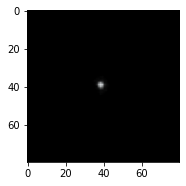

In [6]:
# ランダムに画像表示
n = np.random.randint(0, 500)
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(train_data[n, :, :, :])

In [7]:
# ペアの生成

def make_pairs(images, labels):
    pairImage = []
    pairLabel = []
    CLASS = 4
    label_idx = [np.where(labels == i)[0] for i in range(CLASS)]
    
    for idx in range(len(images)):
        current = images[idx]
        label = labels[idx]
        
        # ポジティブ
        for i in range(1):
          idx_posi = np.random.choice(label_idx[label])
          img_posi = images[idx_posi]
          pairImage.append([current, img_posi])
          pairLabel.append([1])
        
        # ネガティブ
        for j in range(1):
          neg = np.where(labels != label)[0]
          idx_neg = np.random.choice(neg)
          img_neg = images[idx_neg]
          pairImage.append([current, img_neg])
          pairLabel.append([0])

        # # 10C2のペアを作成 => 重いのでペンディング
        # for pair_idx in range(idx+1, len(images)):
        #   pair_img = images[pair_idx]
        #   pair_label = labels[pair_idx]
        #   pairImage.append([current, pair_img])
        #   if label == pair_label:
        #     pairLabel.append([1])
        #   else:
        #     pairLabel.append([0])
    # ランダムに並び替える
    per = np.random.permutation(np.arange(len(images)*2))
    pairImage = np.array(pairImage)
    pairImage = pairImage[per]
    
    pairLabel = np.array(pairLabel)
    pairLabel = pairLabel[per]
    
    # テスト、バリデーションに分割して返す

    xData_train, xData_test, yData_train, yData_test = train_test_split(pairImage, pairLabel, test_size=0.2)
    
    return (xData_train, xData_test, yData_train, yData_test)
    
        

In [8]:
xData_train, xData_test, yData_train, yData_test = make_pairs(train_data, train_label)
xData_train.shape, xData_test.shape, yData_train.shape, yData_test.shape

((1523, 2, 80, 80, 3), (381, 2, 80, 80, 3), (1523, 1), (381, 1))

In [9]:
def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size=2)(x)

    pooled_output = GlobalAveragePooling2D()(x)
    # pooled_output = Flatten()(x)
    outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, outputs)
    return model

model = build_siamese_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 64)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 64)        16448     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 20, 64)        256   

In [10]:
# １つのインスタンスを共有することでパラメータを共有する

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)


In [11]:
# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.sum(K.square(A - B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(1, activation='sigmoid')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [12]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 48)           37616       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model_1[0][0]              

In [13]:
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y*squaredPreds + (1 - y)*squaredMargin)
    return loss

# 0に近い方場合同一として判定

def dist_accuracy(y, preds):
    return K.mean(K.equal(y, K.cast(preds < 0.5, y.dtype)))

In [14]:
model.compile(
    loss = contrastive_loss,
    optimizer = 'adam',
    metrics = [dist_accuracy]
)

In [15]:

def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['dist_accuracy'], label='train acc')
    plt.plot(history.history['val_dist_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

In [16]:
history = model.fit(
    [xData_train[:,0], xData_train[:,1]], yData_train[:],
    validation_data=([xData_test[:,0], xData_test[:,1]], yData_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=5)
)

Epoch 1/100
96/96 [==============================] - 11s 24ms/step - loss: 0.2661 - dist_accuracy: 0.5020 - val_loss: 0.2376 - val_dist_accuracy: 0.5543
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.2297 - dist_accuracy: 0.4935 - val_loss: 0.2104 - val_dist_accuracy: 0.6883
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.2109 - dist_accuracy: 0.5700 - val_loss: 0.1913 - val_dist_accuracy: 0.8269
Epoch 4/100
96/96 [==============================] - 2s 16ms/step - loss: 0.2032 - dist_accuracy: 0.6530 - val_loss: 0.1760 - val_dist_accuracy: 0.8399
Epoch 5/100
96/96 [==============================] - 2s 16ms/step - loss: 0.1890 - dist_accuracy: 0.7194 - val_loss: 0.1743 - val_dist_accuracy: 0.8712
Epoch 6/100
96/96 [==============================] - 2s 17ms/step - loss: 0.1880 - dist_accuracy: 0.7555 - val_loss: 0.1748 - val_dist_accuracy: 0.9056
Epoch 7/100
96/96 [==============================] - 2s 17ms/step - loss: 0.1741 - dist

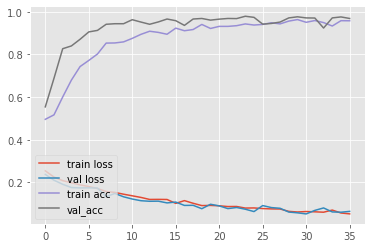

In [17]:
plot_training(history)

In [18]:
# argminを使用した分類への適用
len_content = []
for i, k in enumerate(class_word):
    training_image_paths = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
    len_content.append(len(training_image_paths)//2)
len_content = np.array(len_content)
len_content = np.cumsum(len_content)

base = np.array(base_img)

for i in range(10):
  a = np.random.randint(0, 900)
  ans = len_content.searchsorted(a)
  t = np.array(train_data[a])
  preds = []
  for i in range(4):
    pred = model.predict([t[np.newaxis, ...], base[i][np.newaxis, ...]])
    preds.append(pred[0][0])
  if preds.index(min(preds)) == ans:
    print("OK")
  else:
    print("NG")
  print(min(preds))

OK
0.17869493
OK
0.11386678
OK
0.1375857
NG
0.21578157
OK
0.13178809
OK
0.14492841
OK
0.1336547
OK
0.11630481
OK
0.12066239
OK
0.12747324


# 2.６チャネル化

In [19]:
# 画像のペアの6チャネル化
train_data = []
train_label = []

for i, k in enumerate(class_word):
    training_image_paths = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
    training_image_paths.sort()
    print(training_image_paths[:10])
    cnt = 0
    for j in range(0, len(training_image_paths), 2):
        im = np.array(Image.open(training_image_paths[j]))
        im2 = np.array(Image.open(training_image_paths[j + 1]))
        im_concat = np.concatenate([im, im2], 2)
        im_concat = im_concat.tolist()
        train_data.append(im_concat)
        cnt += 1
    print(cnt)
    train_label.extend([i for m in range(cnt)])

train_data = np.array(train_data)
train_label = np.array(train_label)
train_data.shape,  train_label.shape

['/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000000.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000001.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000003.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000005.m_00000001.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000000.png', '/content/drive/MyDrive/tpxtech/dust/tpxtech_00000006.m_00000001.png']
253
['/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000038.m_00000001.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m_00000000.png', '/content/drive/MyDrive/tpxtech/friction/tpxtech_00000080.m

((952, 80, 80, 6), (952,))

In [20]:
# ペアの生成

def make_pairs(images, labels):
    pairImage = []
    pairLabel = []
    CLASS = 4
    label_idx = [np.where(labels == i)[0] for i in range(CLASS)]
    
    for idx in range(len(images)):
        current = images[idx]
        label = labels[idx]
        
        # ポジティブ
        for i in range(1):
          idx_posi = np.random.choice(label_idx[label])
          img_posi = images[idx_posi]
          pairImage.append([current, img_posi])
          pairLabel.append([1])
        
        # ネガティブ
        for j in range(1):
          neg = np.where(labels != label)[0]
          idx_neg = np.random.choice(neg)
          img_neg = images[idx_neg]
          pairImage.append([current, img_neg])
          pairLabel.append([0])

        # # 10C2のペアを作成 => 重いのでペンディング
        # for pair_idx in range(idx+1, len(images)):
        #   pair_img = images[pair_idx]
        #   pair_label = labels[pair_idx]
        #   pairImage.append([current, pair_img])
        #   if label == pair_label:
        #     pairLabel.append([1])
        #   else:
        #     pairLabel.append([0])

        
    # ランダムに並び替える
    per = np.random.permutation(np.arange(len(images)*2))
    pairImage = np.array(pairImage)
    pairImage = pairImage[per]
    
    pairLabel = np.array(pairLabel)
    pairLabel = pairLabel[per]
    
    # テスト、バリデーションに分割して返す

    xData_train, xData_test, yData_train, yData_test = train_test_split(pairImage, pairLabel, test_size=0.2)
    
    return (xData_train, xData_test, yData_train, yData_test)
    
xData_train, xData_test, yData_train, yData_test = make_pairs(train_data, train_label)
xData_train.shape, xData_test.shape, yData_train.shape, yData_test.shape

((1523, 2, 80, 80, 6), (381, 2, 80, 80, 6), (1523, 1), (381, 1))

In [21]:
IMG_SHAPE = (80, 80, 6)

def build_siamese_model(input_shape, output_dim=48):
    inputs = Input(input_shape)
    x = Conv2D(64, (2,2), padding='same', activation='relu')(inputs)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (2,2), padding='same', activation='relu')(x)
    x = MaxPool2D(pool_size=(2,2))(x)
    x = BatchNormalization()(x)

    # x = Conv2D(128, (2,2), padding='same', activation='relu')(x)
    # x = MaxPool2D(pool_size=2)(x)

    pooled_output = GlobalAveragePooling2D()(x)
    # pooled_output = Flatten()(x)
    outputs = Dense(output_dim)(pooled_output)
    
    model = Model(inputs, outputs)
    return model

model = build_siamese_model(IMG_SHAPE)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 80, 80, 6)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 80, 80, 64)        1600      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 40, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 40, 40, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 40, 40, 64)        16448     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 20, 64)        256 

In [22]:
# １つのインスタンスを共有することでパラメータを共有する

imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)

# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.sum(K.square(A - B), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(1, activation='sigmoid')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 80, 80, 6)]  0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 80, 80, 6)]  0                                            
__________________________________________________________________________________________________
model_4 (Functional)            (None, 48)           38384       input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_4[0][0]              

In [23]:
model.compile(
    loss = contrastive_loss,
    optimizer = 'adam',
    metrics = [dist_accuracy]
)

In [24]:
history = model.fit(
    [xData_train[:,0], xData_train[:,1]], yData_train[:],
    validation_data=([xData_test[:,0], xData_test[:,1]], yData_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=5)
)

Epoch 1/100
96/96 [==============================] - 3s 26ms/step - loss: 0.3142 - dist_accuracy: 0.5174 - val_loss: 0.2907 - val_dist_accuracy: 0.4665
Epoch 2/100
96/96 [==============================] - 2s 22ms/step - loss: 0.2548 - dist_accuracy: 0.5174 - val_loss: 0.2572 - val_dist_accuracy: 0.4651
Epoch 3/100
96/96 [==============================] - 2s 22ms/step - loss: 0.2526 - dist_accuracy: 0.4807 - val_loss: 0.2610 - val_dist_accuracy: 0.4625
Epoch 4/100
96/96 [==============================] - 2s 22ms/step - loss: 0.2529 - dist_accuracy: 0.4902 - val_loss: 0.2546 - val_dist_accuracy: 0.4860
Epoch 5/100
96/96 [==============================] - 2s 21ms/step - loss: 0.2502 - dist_accuracy: 0.5009 - val_loss: 0.2535 - val_dist_accuracy: 0.4860
Epoch 6/100
96/96 [==============================] - 2s 22ms/step - loss: 0.2510 - dist_accuracy: 0.4624 - val_loss: 0.2541 - val_dist_accuracy: 0.4722
Epoch 7/100
96/96 [==============================] - 2s 22ms/step - loss: 0.2497 - dist_

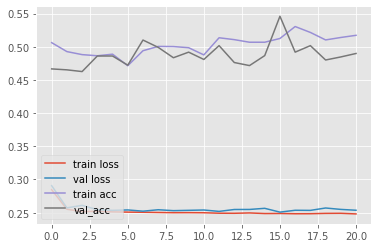

In [25]:
plot_training(history)

# 3.多クラス分類

In [26]:

# x:[元画像, エラー画像]のペア y:ラベルのone hot表現を作る

train_data = []
train_label = []

for i, k in enumerate(class_word):
  training_image_path = get_dataset_slice_paths('/content/drive/MyDrive/tpxtech/', k)
  training_image_path.sort()
  for j in range(0, len(training_image_path), 2):
    im1 = np.array(Image.open(training_image_path[j]))
    im2 = np.array(Image.open(training_image_path[j+1]))
    train_data.append([im1, im2])
    one_hot = [1 if m == i else 0 for m in range(4)]
    train_label.append(one_hot)

train_data = np.array(train_data)
train_label = np.array(train_label)

train_data.shape, train_label.shape

((952, 2, 80, 80, 3), (952, 4))

In [27]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size = 0.2)
train = []
label = []
for i in range(len(x_train)):
  train.append(x_train[i])
  train.append([np.rot90(x_train[i,0]), np.rot90(x_train[i,1])])
  train.append([np.rot90(x_train[i,0], 2), np.rot90(x_train[i,1], 2)])
  label.append(y_train[i])
  label.append(y_train[i])
  label.append(y_train[i])
x_train = np.array(train)
y_train = np.array(label)

x_train.shape, y_train.shape

((2283, 2, 80, 80, 3), (2283, 4))

In [28]:
# １つのインスタンスを共有することでパラメータを共有する

IMG_SHAPE = (80, 80, 3)
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)

feature_extractor = build_siamese_model(IMG_SHAPE)
modelA = feature_extractor(imgA)
modelB = feature_extractor(imgB)

# ユークリッド距離を計算する関数
# レイヤとして埋め込むためにkerasで関数を生成する

def euclidean_distance(vectors):
    (A, B) = vectors
    sumSquared = K.square(A - B)
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))


dist = Lambda(euclidean_distance)([modelA, modelB])
outputs = Dense(4, activation='softmax')(dist)
model = Model(inputs=[imgA, imgB], outputs=outputs)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
model_6 (Functional)            (None, 48)           37616       input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 48)           0           model_6[0][0]              

In [29]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = 'accuracy'
)

In [30]:
BATCH_SIZE = 16
history = model.fit(
    [x_train[:,0], x_train[:,1]], y_train[:],
    validation_data=([x_test[:,0], x_test[:,1]], y_test[:]),
    batch_size = BATCH_SIZE,
    epochs = 100,
    callbacks = EarlyStopping(monitor='val_loss', patience=10)
)

Epoch 1/100
143/143 [==============================] - 4s 18ms/step - loss: 1.1568 - accuracy: 0.5842 - val_loss: 0.8422 - val_accuracy: 0.7173
Epoch 2/100
143/143 [==============================] - 2s 14ms/step - loss: 0.9198 - accuracy: 0.6897 - val_loss: 0.6884 - val_accuracy: 0.7382
Epoch 3/100
143/143 [==============================] - 2s 15ms/step - loss: 0.7900 - accuracy: 0.7523 - val_loss: 1.0808 - val_accuracy: 0.7382
Epoch 4/100
143/143 [==============================] - 2s 15ms/step - loss: 0.6683 - accuracy: 0.8069 - val_loss: 0.7827 - val_accuracy: 0.8220
Epoch 5/100
143/143 [==============================] - 2s 14ms/step - loss: 0.5762 - accuracy: 0.8265 - val_loss: 0.7506 - val_accuracy: 0.8272
Epoch 6/100
143/143 [==============================] - 2s 14ms/step - loss: 0.5257 - accuracy: 0.8297 - val_loss: 0.5553 - val_accuracy: 0.8325
Epoch 7/100
143/143 [==============================] - 2s 14ms/step - loss: 0.5405 - accuracy: 0.8254 - val_loss: 0.5871 - val_accuracy:

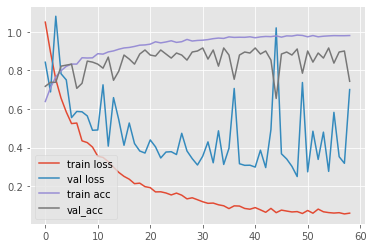

In [31]:
def plot_training(history):
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['accuracy'], label='train acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc = 'lower left')

plot_training(history)